In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pylab
import re
import csv
from scipy.integrate import simps 
from numpy import trapz  
from IPython.display import display, HTML  # To display correct tables
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import sklearn.metrics as metrics
import matplotlib.lines as mlines
plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (16.0, 8.0)
cp = sns.color_palette()

def figsize(width=100, height=15):
    pylab.rcParams['figure.figsize'] = (width, height)

In [2]:
class Pi_rating:
    
    def __init__(self, c=None, l=None, gamma=None):
        self.c = c
        self.l = l
        self.gamma = gamma
    
    def _aux_phi(self,e):
        return self.c*np.log(e+1)
    
    def _aux_predict_difference(self,r):
        r2=np.abs(r)
        g_pred = np.exp(r2/self.c) - 1
        if r>0:
            return g_pred
        else:
            return (-g_pred)
    
    def _aux_error(self,g,r):
        g_pred = self._aux_predict_difference(r)
        return np.abs(g_pred-g)
    
    def pi_rating(self, games, init_rating=None):
        
        if self.c is None or self.l is None or self.gamma is None:
            raise ValueError("c, l or gamma attribute has not been instantiated.")
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        team_home_ratings = {}
        team_away_ratings = {}
        if init_rating is None:
            for team in teams:
                team_home_ratings[team] = 0
                team_away_ratings[team] = 0
        else:
            for team in teams:
               
            
                if team in init_rating:
                    team_ratings[team] = init_rating[team]
                else:
                    team_ratings[team] = 0
        # Process
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            # retrieve current values
            rhh = team_home_ratings[home_team]
            rha = team_away_ratings[home_team]
            rah = team_home_ratings[away_team]
            raa = team_away_ratings[away_team]
            # Calculate new values
            g = row["home_score"] - row["away_score"]
            g_pred_home_team = self._aux_predict_difference(rhh)
            g_pred_away_team = self._aux_predict_difference(raa)
            g_pred = g_pred_home_team - g_pred_away_team
            e = np.abs(g - g_pred)
            p = self._aux_phi(e)
            # Compute
            if g_pred < g:
                new_rhh = rhh + p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa - p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            else :
                new_rhh = rhh - p*self.l
                new_rha = rha + (new_rhh - rhh)*self.gamma
                new_raa = raa + p*self.l
                new_rah = rah + (new_raa - raa)*self.gamma
            # Update
            # ----- Store result
            games.loc[games_index, "home_r_at_home"] = new_rhh
            games.loc[games_index, "home_r_away"] = new_rha
            games.loc[games_index, "away_r_at_home"] = new_rah
            games.loc[games_index, "away_r_away"] = new_raa
            games.loc[games_index, "prev_home_r_at_home"] = rhh
            games.loc[games_index, "prev_home_r_away"] = rha
            games.loc[games_index, "prev_away_r_at_home"] = rah
            games.loc[games_index, "prev_away_r_away"] = raa
            # ----- Update function helper variables
            team_home_ratings[home_team] = new_rhh
            team_away_ratings[home_team] = new_rha
            team_home_ratings[away_team] = new_rah
            team_away_ratings[away_team] = new_raa
        return games, team_home_ratings, team_away_ratings

    # New parameter: percentage of away wins among all the wins
    
    def awayshape(self, games):
        games = games.sort_values(["season", "season_order"])
        teams = set(games["home_team"]) | set(games["away_team"])
        prev_number_away_wins = {}
        prev_number_wins = {}
       
    
        prev_score = {}
        for team in teams:
            prev_number_away_wins[team] = 1
            prev_number_wins[team] = 1
            prev_score[team] = 0
        for games_index, row in games.iterrows():
            home_team = row["home_team"]
            away_team = row["away_team"]
            h1 = prev_number_away_wins[home_team]
            h2 = prev_number_wins[home_team]
            a1 = prev_number_away_wins[away_team]
            a2 = prev_number_wins[away_team]
            rh = h1/h2
            ra = a1/a2
            home_s = prev_score[home_team]
            away_s = prev_score[away_team]
            games.loc[games_index, "home_awayshape"] = rh
            games.loc[games_index, "away_awayshape"] = ra
            games.loc[games_index, "home_number_of_wins"] = h2
            games.loc[games_index, "away_number_of_wins"] = a2
            games.loc[games_index, "home_number_of_wins_away"] = h1
            games.loc[games_index, "away_number_of_wins_away"] = a1
            games.loc[games_index, "home_prev_score"] = home_s
            games.loc[games_index, "away_prev_score"] = away_s
            if row["home_score"] < row["away_score"]:
                prev_number_away_wins[away_team]+= 1
                prev_number_wins[away_team]+= 1
            elif row["home_score"] > row ["away_score"]:
                prev_number_wins[home_team]+= 1
            prev_score[home_team] = row["home_score"]
            prev_score[away_team] = row["away_score"]
        return games

In [3]:
class Evaluation:
    
    def Preprocessing(self, df):
        df = df.drop(columns=["season_order","home_team","away_team","home_win_main_odd","home_loss_main_odd","draw_main_odd","n_bookies","season","lnr_id","datetime","home_r_at_home","home_r_away","away_r_at_home","away_r_away","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away"])
        return(df)
                    
    def Splitting_and_Scaling(self,df):
        sc = StandardScaler()
        X = df.drop(columns=["home_score","away_score"])
        y = df["home_score"] > df["away_score"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        return X_train_std, X_test_std, y_train, y_test
    
    def RandomForestProcessing(self, X_train, y_train, X_test):
        rfc = RandomForestClassifier(n_estimators=100)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict_proba(X_test)[:,1]
        return (y_pred)
    
    def LogisticRegressionProcessing(self, X_train, y_train, X_test):
        lr = LogisticRegression(solver='lbfgs') 
        lr.fit(X_train, y_train)
        y_pred = lr.predict_proba(X_test)[:, 1]
        return (y_pred)
    
    def GradientBoostingProcessing(self, X_train, y_train, X_test):
        gb = GradientBoostingClassifier()
        gb.fit(X_train, y_train)
        y_pred = gb.predict_proba(X_test)[:, 1]
        return(y_pred)

    def SVMProcessing(self, X_train, y_train, X_test):
        svclassifier = SVC(kernel='rbf',probability=True) #choosing the RBF kernel and allowing the estimation of probability
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict_proba(X_test)[:, 1]
        return(y_pred)
    
    #Function to find the threshold that optimizes the recall
    
    def ThresholdtoOptimize_Recall(self, y_pred, y_test, accuracy_min, precision_min=0):
        #Default: precision_min = 0: does not take into account precision
        #The lower the threshold, the higher the recall
        thresholds = np.linspace(0, 1, 200)
        t = 1
        for threshold in thresholds:
            z = y_pred >= threshold
            accuracy = np.sum(z == y_test) / len(y_test)
            precision = metrics.precision_score(y_test, z)
            if (accuracy >= accuracy_min) & (precision >= precision_min) & (threshold <= t):
                t = threshold
        return t
        
    #Function to find the threshold that optimizes the accuracy
        
    def ThresholdtoOptimize_Accuracy(self, y_pred, y_test):
        accuracies = []
        thresholds = np.linspace(0, 1, 200)
        for threshold in thresholds:
            z = y_pred >= threshold
            accuracies.append(np.sum(z == y_test) / len(y_test))
        return (thresholds[np.argmax(accuracies)])
    
    #Function to find the threshold that optimizes the precision
    
    def ThresholdtoOptimize_Precision(self, y_pred, y_test, accuracy_min, recall_min=0):
        #Default: recall_min = 0: does not take into account recall
        #The higher the threshold, the higher the precision
        thresholds = np.linspace(0, 1, 200)
        t = 0
        for threshold in thresholds:
            z = y_pred >= threshold
            accuracy = np.sum(z == y_test) / len(y_test)
            recall = metrics.recall_score(y_test, z)
            if (accuracy >= accuracy_min) & (recall >= recall_min) & (threshold >= t):
                t = threshold
        return t
        
    def Plot_Model_Evaluation(self, y_pred, y_test, t=None):
        
        #t is the threshold for the classification, default: maximizing the accuracy
        #Plot ROC curve and accuracy according to threshold curve
        figsize(16, 16)
        true_positive_rates = []
        false_positive_rates = []
        accuracies = []
        thresholds = np.linspace(0, 1, 200)
        for threshold in thresholds:
            z = y_pred >= threshold
            true_positive_rates.append(np.sum((z == 1) & (y_test == 1)) / np.sum(y_test))
            false_positive_rates.append(np.sum((z == 1) & (y_test == 0)) / np.sum(1 - y_test))
            accuracies.append(np.sum(z == y_test) / len(y_test))
        plt.subplot(2, 1, 1)
        plt.plot(false_positive_rates, true_positive_rates, "--o")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("ROC Curve")
        plt.plot([0, 1], [0, 1])
        plt.subplot(2, 1, 2)
        plt.plot(thresholds, accuracies, "--o")
        plt.xlabel("Threshold")
        plt.ylabel("Accuracy")
        plt.title("Accuracy according to threshold")
        plt.show()
        figsize()

        #Plot other metrics
        true_positive_rates.reverse()
        false_positive_rates.reverse()
        if t is None:
            z = y_pred >= thresholds[np.argmax(accuracies)]
            print("Best Accuracy:", max(accuracies))
            # Compute the area using the composite trapezoidal rule. 
            AUC = trapz(true_positive_rates, x = false_positive_rates) 
            print("AUC =", AUC)
            print("Precision (The precision is intuitively the ability of the classifier not to label as positive a sample that is negative):", metrics.precision_score(y_test, z))
            print("Recall (The recall is intuitively the ability of the classifier to find all the positive samples)", metrics.recall_score(y_test,z))
        else:
            z = y_pred >= t
            Accuracy = np.sum(z == y_test) / len(y_test)
            print("Accuracy:", Accuracy)
            # Compute the area using the composite trapezoidal rule. 
            AUC = trapz(true_positive_rates, x = false_positive_rates) 
            print("AUC =", AUC)
            print("Precision (The precision is intuitively the ability of the classifier not to label as positive a sample that is negative):", metrics.precision_score(y_test, z))
            print("Recall (The recall is intuitively the ability of the classifier to find all the positive samples)", metrics.recall_score(y_test,z)) 
            
    def Metrics_Model_Evaluation(self, y_pred, y_test, t=None):
        #t is the threshold for classification, default: maximizing accuracy 
        true_positive_rates = []
        false_positive_rates = []
        accuracies = []
        thresholds = np.linspace(0, 1, 200)
        for threshold in thresholds:
            z = y_pred >= threshold
            true_positive_rates.append(np.sum((z == 1) & (y_test == 1)) / np.sum(y_test))
            false_positive_rates.append(np.sum((z == 1) & (y_test == 0)) / np.sum(1 - y_test))
            accuracies.append(np.sum(z == y_test) / len(y_test))
        true_positive_rates.reverse()
        false_positive_rates.reverse()
        if t is None:
            z = y_pred >= thresholds[np.argmax(accuracies)]
            d = {"Accuracy" : max(accuracies), "Threshold" : thresholds[np.argmax(accuracies)], "AUC" : trapz(true_positive_rates, x = false_positive_rates), "Precision" : metrics.precision_score(y_test, z), "Recall" : metrics.recall_score(y_test,z)}
        else:
            z = y_pred >= t
            Accuracy = np.sum(z == y_test) / len(y_test)           
            d = {"Accuracy" : Accuracy, "Threshold" : t, "AUC" : trapz(true_positive_rates, x = false_positive_rates), "Precision" : metrics.precision_score(y_test, z), "Recall" : metrics.recall_score(y_test,z)}
        return d, true_positive_rates, false_positive_rates

    def EvaluateAllRandomForest(self,df,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        #Plot the metrics and the ROC curve and accuracy according to threshold for the Random Forest method
        df = self.Preprocessing(df)
        X_train, X_test, y_train, y_test = self.Splitting_and_Scaling(df)
        y_pred = self.RandomForestProcessing(X_train, y_train, X_test)
        t = 0
        if OptimizeRecall:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif precision_min is None:
                raise ValueError("precision_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Recall(y_pred,y_test,accuracy_min,precision_min=precision_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        elif OptimizePrecision:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif recall_min is None:
                raise ValueError("recall_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Precision(y_pred,y_test,accuracy_min,recall_min=recall_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        else:
            self.Plot_Model_Evaluation(y_pred,y_test)
        
    def EvaluateAllLogisticRegression(self,df,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        #Plot the metrics and the ROC curve and accuracy according to threshold for Logistic Regression method
        df = self.Preprocessing(df)
        X_train, X_test, y_train, y_test = self.Splitting_and_Scaling(df)
        y_pred = self.LogisticRegressionProcessing(X_train, y_train, X_test)
        t = 0
        if OptimizeRecall:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif precision_min is None:
                raise ValueError("precision_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Recall(y_pred,y_test,accuracy_min,precision_min=precision_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        elif OptimizePrecision:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif recall_min is None:
                raise ValueError("recall_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Precision(y_pred,y_test,accuracy_min,recall_min=recall_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        else:
            self.Plot_Model_Evaluation(y_pred,y_test)
        
    def EvaluateAllGradientBoosting(self,df,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        #Plot the metrics and the ROC curve and accuracy according to threshold for Gradient Boosting method
        df = self.Preprocessing(df)
        X_train, X_test, y_train, y_test = self.Splitting_and_Scaling(df)
        y_pred = self.GradientBoostingProcessing(X_train, y_train, X_test)
        t = 0
        if OptimizeRecall:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif precision_min is None:
                raise ValueError("precision_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Recall(y_pred,y_test,accuracy_min,precision_min=precision_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        elif OptimizePrecision:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif recall_min is None:
                raise ValueError("recall_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Precision(y_pred,y_test,accuracy_min,recall_min=recall_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        else:
            self.Plot_Model_Evaluation(y_pred,y_test)

    def EvaluateAllSVM(self,df,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        #Plot the metrics and the ROC curve and accuracy according to threshold for Gradient Boosting method
        df = self.Preprocessing(df)
        X_train, X_test, y_train, y_test = self.Splitting_and_Scaling(df)
        y_pred = self.SVMProcessing(X_train, y_train, X_test)
        t = 0
        if OptimizeRecall:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif precision_min is None:
                raise ValueError("precision_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Recall(y_pred,y_test,accuracy_min,precision_min=precision_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        elif OptimizePrecision:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif recall_min is None:
                raise ValueError("recall_min argument missing")
            else:
                t = self.ThresholdtoOptimize_Precision(y_pred,y_test,accuracy_min,recall_min=recall_min)
                self.Plot_Model_Evaluation(y_pred,y_test,t=t)
        else:
            self.Plot_Model_Evaluation(y_pred,y_test)
        
    def ModelComparison(self,df,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        #Compare the metrics of the models, output: a dataframe
        #Possibility to choose whether to optimize recall, precision or accuracy, default accuracy
        figsize(16, 16)
        df = self.Preprocessing(df)
        X_train, X_test, y_train, y_test = self.Splitting_and_Scaling(df)
        y_pred_Rf = self.RandomForestProcessing(X_train, y_train, X_test)
        y_pred_Lr = self.LogisticRegressionProcessing(X_train, y_train, X_test)
        y_pred_Gb = self.GradientBoostingProcessing(X_train, y_train, X_test)
        y_pred_Svm = self.SVMProcessing(X_train, y_train, X_test)
        t_Rf = self.ThresholdtoOptimize_Accuracy(y_pred_Rf, y_test)
        t_Lr = self.ThresholdtoOptimize_Accuracy(y_pred_Lr, y_test)
        t_Gb = self.ThresholdtoOptimize_Accuracy(y_pred_Gb, y_test)
        t_Svm = self.ThresholdtoOptimize_Accuracy(y_pred_Svm, y_test)
        if OptimizeRecall:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif precision_min is None:
                raise ValueError("precision_min argument missing")
            else:
                t_Rf = self.ThresholdtoOptimize_Recall(y_pred_Rf, y_test,accuracy_min,precision_min=precision_min)
                t_Lr = self.ThresholdtoOptimize_Recall(y_pred_Lr, y_test,accuracy_min,precision_min=precision_min)
                t_Gb = self.ThresholdtoOptimize_Recall(y_pred_Gb, y_test,accuracy_min,precision_min=precision_min)
                t_Svm = self.ThresholdtoOptimize_Recall(y_pred_Svm, y_test,accuracy_min,precision_min=precision_min)
        if OptimizePrecision:
            if accuracy_min is None:
                raise ValueError("accuracy_min argument missing")
            elif recall_min is None:
                raise ValueError("recall_min argument missing")
            else:
                t_Rf = self.ThresholdtoOptimize_Precision(y_pred_Rf, y_test,accuracy_min,recall_min=recall_min)
                t_Lr = self.ThresholdtoOptimize_Precision(y_pred_Lr, y_test,accuracy_min,recall_min=recall_min)
                t_Gb = self.ThresholdtoOptimize_Precision(y_pred_Gb, y_test,accuracy_min,recall_min=recall_min)
                t_Svm = self.ThresholdtoOptimize_Precision(y_pred_Svm, y_test,accuracy_min,recall_min=recall_min)
        Results_Rf, tpRf, fpRf = self.Metrics_Model_Evaluation(y_pred_Rf,y_test,t=t_Rf)
        Results_Lr, tpLr, fpLr = self.Metrics_Model_Evaluation(y_pred_Lr,y_test,t=t_Lr)
        Results_Gb, tpGb, fpGb = self.Metrics_Model_Evaluation(y_pred_Gb,y_test,t=t_Gb)
        Results_Svm, tpSvm, fpSvm = self.Metrics_Model_Evaluation(y_pred_Svm,y_test,t=t_Svm)
        d_Rf = pd.DataFrame(Results_Rf, index=["RandomForest"])
        d_Lr = pd.DataFrame(Results_Lr, index=["LogisticRegression"])
        d_Gb = pd.DataFrame(Results_Gb, index=["GradientBoosting"])
        d_Svm = pd.DataFrame(Results_Svm, index=["SVM"])
        d = pd.concat([d_Rf,d_Lr,d_Gb,d_Svm])
        plt.plot(fpRf, tpRf, "r")
        plt.plot(fpLr, tpLr, "b")
        plt.plot(fpGb, tpGb, "g")
        plt.plot(fpSvm, tpSvm, "c")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.title("ROC Curves")
        RandomForest = mlines.Line2D([], [], color='red',
                          markersize=15, label="RandomForest")
        LogisticRegression = mlines.Line2D([], [], color='blue',
                          markersize=15, label='LogisticRegression')
        GradientBoosting = mlines.Line2D([], [], color='green',
                          markersize=15, label="GradientBoosting")
        SVM = mlines.Line2D([], [], color='cyan',
                          markersize=15, label="SVM")
        plt.legend(handles=[RandomForest,LogisticRegression,GradientBoosting,SVM],loc=1)
        display(d)

        
        

In [4]:
class Prediction:
    
    def Preprocessing(self, df):
        df = df.drop(columns=["season_order","home_team","away_team","home_win_main_odd","home_loss_main_odd","draw_main_odd","n_bookies","season","lnr_id","datetime","home_r_at_home","home_r_away","away_r_at_home","away_r_away","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away"])
        return(df)

    def RandomForestProcessing(self, X_train, y_train, X_test):
        rfc = RandomForestClassifier(n_estimators=100)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict_proba(X_test)[:,1]
        importances = (rfc.feature_importances_).tolist()
        return y_pred, importances

    def LogisticRegressionProcessing(self, X_train, y_train, X_test):
        lr = LogisticRegression(solver='lbfgs')
        lr.fit(X_train, y_train)
        y_pred = lr.predict_proba(X_test)[:, 1]
        importances = (lr.coef_).tolist()[0]
        return y_pred, importances
    
    def GradientBoostingProcessing(self, X_train, y_train, X_test):
        gb = GradientBoostingClassifier()
        gb.fit(X_train, y_train)
        y_pred = gb.predict_proba(X_test)[:, 1]
        importances = (gb.feature_importances_).tolist()
        return y_pred, importances

    def SVMProcessing(self, X_train, y_train, X_test):
        svclassifier = SVC(kernel='rbf',probability=True) #choosing the RBF kernel and allowing the estimation of probability
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict_proba(X_test)[:, 1]
        #It is not possible to determine feature importance for SVM with a non linear kernel
        return y_pred
    
    def AddProbabilityofWinning(self,trainingdata,newdata,method):
        #Add the probability of winning to the dataframe
        df = self.Preprocessing(trainingdata)
        newdatabis = newdata.copy(deep=True)
        df2 = self.Preprocessing(newdatabis)
        sc = StandardScaler()
        X_train = df.drop(columns=["home_score","away_score"])
        y_train = df["home_score"] > df["away_score"]
        X_train_std = sc.fit_transform(X_train)
        X_std = sc.fit_transform(df2)
        if method == "RandomForest":
            y_pred,_ = self.RandomForestProcessing(X_train_std, y_train, X_std)
        elif method == "LogisticRegression":
            y_pred,_ = self.LogisticRegressionProcessing(X_train_std, y_train, X_std)
        elif method == "GradientBoosting":
            y_pred,_ = self.GradientBoostingProcessing(X_train_std, y_train, X_std) 
        elif method == "SVM":
            y_pred = self.SVMProcessing(X_train_std, y_train, X_std)
        newdata["ProbabilityofWinning"] = y_pred
        return(newdata)
        
    def TeamsMostLikelytoWin(self,trainingdata,newdata,method,threshold=0.5):
        #returns a dataframe only with teams whose probability of winning is above the threshold
        d = self.AddProbabilityofWinning(trainingdata,newdata,method)
        df = d[d["ProbabilityofWinning"] >= threshold]
        return(df)

    def MostImportantFeatures(self,trainingdata,method):
        figsize(16,16)
        df = self.Preprocessing(trainingdata)
        sc = StandardScaler()
        X = df.drop(columns=["home_score","away_score"])
        l = list(X)
        y = df["home_score"] > df["away_score"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        if method == "LogisticRegression":
            _,f = self.LogisticRegressionProcessing(X_train_std, y_train, X_test)
            print("The coefficients are printed.")
        elif method == "GradientBoosting":
            _,f = self.GradientBoostingProcessing(X_train_std, y_train, X_test)
            print("For each feature, the score is the percentage of contribution of the feature to the final result.")
        elif method == "SVM":
            raise ValueError("Not possible to get feature importances with non linear kernel")
        else:
            _,f = self.RandomForestProcessing(X_train_std, y_train, X_test)
            print("For each feature, the score is the percentage of contribution of the feature to the final result.")
        x = np.arange(len(l))  # the label locations
        width = 0.35  # the width of the bars
        fig, ax = plt.subplots()
        rects = ax.bar(x, f, width)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Most important features')
        ax.set_xticks(x)
        ax.set_xticklabels(l)
        ax.legend()
        fig.tight_layout()
        plt.show()


In [18]:
class Optimization:
    
    def Preprocessing(self, df):
        df = df.drop(columns=["season_order","home_team","away_team","home_win_main_odd","home_loss_main_odd","draw_main_odd","n_bookies","season","lnr_id","datetime","home_r_at_home","home_r_away","away_r_at_home","away_r_away","home_number_of_wins","away_number_of_wins","home_number_of_wins_away","away_number_of_wins_away"])
        return(df)
    
    def ThresholdtoOptimize_Recall(self, y_pred, y_test, accuracy_min, precision_min=0):
        #Default: precision_min = 0: does not take into account precision
        #The lower the threshold, the higher the recall
        thresholds = np.linspace(0, 1, 200)
        t = 1
        for threshold in thresholds:
            z = y_pred >= threshold
            accuracy = np.sum(z == y_test) / len(y_test)
            precision = metrics.precision_score(y_test, z)
            if (accuracy >= accuracy_min) & (precision >= precision_min) & (threshold <= t):
                t = threshold
        return t
            
    #Function to find the threshold that optimizes the accuracy
        
    def ThresholdtoOptimize_Accuracy(self, y_pred, y_test):
        accuracies = []
        thresholds = np.linspace(0, 1, 200)
        for threshold in thresholds:
            z = y_pred >= threshold
            accuracies.append(np.sum(z == y_test) / len(y_test))
        return (thresholds[np.argmax(accuracies)])
    
    #Function to find the threshold that optimizes the precision
    
    def ThresholdtoOptimize_Precision(self, y_pred, y_test, accuracy_min, recall_min=0):
        #Default: recall_min = 0: does not take into account recall
        #The higher the threshold, the higher the precision
        thresholds = np.linspace(0, 1, 200)
        t = 0
        for threshold in thresholds:
            z = y_pred >= threshold
            accuracy = np.sum(z == y_test) / len(y_test)
            recall = metrics.recall_score(y_test, z)
            if (accuracy >= accuracy_min) & (recall >= recall_min) & (threshold >= t):
                t = threshold
        return t
    
    def RandomForestProcessing(self, X_train, y_train, X_test):
        rfc = RandomForestClassifier(n_estimators=100)
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict_proba(X_test)[:,1]
        importances = (rfc.feature_importances_).tolist()
        return y_pred, importances

    def LogisticRegressionProcessing(self, X_train, y_train, X_test):
        lr = LogisticRegression(solver='lbfgs')
        lr.fit(X_train, y_train)
        y_pred = lr.predict_proba(X_test)[:, 1]
        importances = (lr.coef_).tolist()[0]
        return y_pred, importances
    
    def GradientBoostingProcessing(self, X_train, y_train, X_test):
        gb = GradientBoostingClassifier()
        gb.fit(X_train, y_train)
        y_pred = gb.predict_proba(X_test)[:, 1]
        importances = (gb.feature_importances_).tolist()
        return y_pred, importances

    def SVMProcessing(self, X_train, y_train, X_test):
        svclassifier = SVC(kernel='rbf',probability=True) #choosing the RBF kernel and allowing the estimation of probability
        svclassifier.fit(X_train, y_train)
        y_pred = svclassifier.predict_proba(X_test)[:, 1]
        #It is not possible to determine feature importance for SVM with a non linear kernel
        l = []
        return y_pred,l
    
    def ProcessModel(self, X_train, y_train, X_test, method):
        if method == "Random Forest":
            return self.RandomForestProcessing(X_train,y_train,X_test)
        elif method == "LogisticRegression":
            return self.LogisticRegressionProcessing(X_train,y_train,X_test)
        elif method == "GradientBoosting":
            return self.GradientBoostingProcessing(X_train,y_train,X_test)
        else:
            return self.SVMProcessing(X_train,y_train,X_test)

    def Metrics_Model_Evaluation(self, y_pred, y_test, t=None):
        #t is the threshold for classification, default: maximizing accuracy 
        true_positive_rates = []
        false_positive_rates = []
        accuracies = []
        thresholds = np.linspace(0, 1, 200)
        for threshold in thresholds:
            z = y_pred >= threshold
            true_positive_rates.append(np.sum((z == 1) & (y_test == 1)) / np.sum(y_test))
            false_positive_rates.append(np.sum((z == 1) & (y_test == 0)) / np.sum(1 - y_test))
            accuracies.append(np.sum(z == y_test) / len(y_test))
        true_positive_rates.reverse()
        false_positive_rates.reverse()
        if t is None:
            z = y_pred >= thresholds[np.argmax(accuracies)]
            d = {"Accuracy" : max(accuracies), "Threshold" : thresholds[np.argmax(accuracies)], "AUC" : trapz(true_positive_rates, x = false_positive_rates), "Precision" : metrics.precision_score(y_test, z), "Recall" : metrics.recall_score(y_test,z)}
        else:
            z = y_pred >= t
            Accuracy = np.sum(z == y_test) / len(y_test)           
            d = {"Accuracy" : Accuracy, "Threshold" : t, "AUC" : trapz(true_positive_rates, x = false_positive_rates), "Precision" : metrics.precision_score(y_test, z), "Recall" : metrics.recall_score(y_test,z)}
        return d, true_positive_rates, false_positive_rates
    
    def kfoldcrossvalidation(self, X_train,y_train,OptimizeAUC=False,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        criterion = "a"
        if OptimizeAUC:
            criterion = "AUC"
        elif OptimizeRecall:
            criterion = "Recall"
        elif OptimizePrecision:
            criterion = "Precision"
        else:
            criterion = "Accuracy"
        kfold = KFold(n_splits=5, shuffle=True)
        criterion_values = []
        best_models = []
        Rf_thresholds = []
        Lr_thresholds = []
        Gb_thresholds = []
        Svm_thresholds = []
        models = ["RandomForest","LogisticRegression","GradientBoosting","SVM"]
        for k, (sub_train_index, sub_test_index) in enumerate(kfold.split(X_train)):
            best_criterion_value = -1
            best_model = "a"
            xtrain, xtest = X_train[sub_train_index], X_train[sub_test_index]
            ytrain, ytest = y_train[sub_train_index], y_train[sub_test_index]
            for model in models:
                if model == "RandomForest":
                    y_pred,_ = self.RandomForestProcessing(xtrain, ytrain, xtest)
                elif model == "LogisticRegression":
                    y_pred,_ = self.LogisticRegressionProcessing(xtrain, ytrain, xtest)
                elif model == "GradientBoosting":
                    y_pred,_ = self.GradientBoostingProcessing(xtrain, ytrain, xtest)
                else:
                    y_pred,_ = self.SVMProcessing(xtrain, ytrain, xtest)
                
                if OptimizeRecall:
                    t = self.ThresholdtoOptimize_Recall(y_pred,ytest,accuracy_min,precision_min=precision_min)
                elif OptimizePrecision:
                    t = self.ThresholdtoOptimize_Precision(y_pred,ytest,accuracy_min,recall_min=recall_min)
                else:
                    t = self.ThresholdtoOptimize_Accuracy(y_pred,ytest)
                d,_,_ = self.Metrics_Model_Evaluation(y_pred,ytest,t=t)

                if d[criterion] > best_criterion_value:
                    best_criterion_value = d[criterion]
                    best_model = model
                if model == "RandomForest":
                    Rf_thresholds.append(t)
                elif model == "LogisticRegression":
                    Lr_thresholds.append(t)
                elif model == "GradientBoosting":
                    Gb_thresholds.append(t)
                else:
                    Svm_thresholds.append(t)
            best_models.append(best_model)
            criterion_values.append(best_criterion_value)
        i = -1
        best = "a"
        for model in models:
            if best_models.count(model) > i:
                i = best_models.count(model)
                best = model
        th = 0
        if best == "RandomForest":
            th = np.mean(Rf_thresholds)
        elif best == "LogisticRegression":
            th = np.mean(Lr_thresholds)
        elif best == "GradientBoosting":
            th = np.mean(Gb_thresholds)
        else:
            th = np.mean(Svm_thresholds)
        return best, th
    
    def AddProbabilityofWinning(self,trainingdata,newdata,method):
        #Add the probability of winning to the dataframe
        df = self.Preprocessing(trainingdata)
        newdatabis = newdata.copy(deep=True)
        df2 = self.Preprocessing(newdatabis)
        sc = StandardScaler()
        X_train = df.drop(columns=["home_score","away_score"])
        y_train = df["home_score"] > df["away_score"]
        X_train_std = sc.fit_transform(X_train)
        X_std = sc.fit_transform(df2)
        y_pred,_ = self.ProcessModel(X_train_std, y_train, X_std, method) 
        newdata["ProbabilityofWinning"] = y_pred
        return(newdata)
    
    def TeamsMostLikelytoWin(self,trainingdata,newdata,method,threshold=0.5):
        #returns a dataframe only with teams whose probability of winning is above the threshold
        d = self.AddProbabilityofWinning(trainingdata,newdata,method)
        df = d[d["ProbabilityofWinning"] >= threshold]            
        return(df)
        
    def MostImportantFeatures(self,trainingdata,method):
        figsize(16,16)
        df = self.Preprocessing(trainingdata)
        sc = StandardScaler()
        X = df.drop(columns=["home_score","away_score"])
        l = list(X)
        y = df["home_score"] > df["away_score"]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        X_train_std = sc.fit_transform(X_train)
        X_test_std = sc.transform(X_test)
        if method == "LogisticRegression":
            _,f = self.LogisticRegressionProcessing(X_train_std, y_train, X_test)
            print("The coefficients are printed.")
        elif method == "GradientBoosting":
            _,f = self.GradientBoostingProcessing(X_train_std, y_train, X_test)
            print("For each feature, the score is the percentage of contribution of the feature to the final result.")
        elif method == "SVM":
            raise ValueError("Not possible to get feature importances with non linear kernel")
        else:
            _,f = self.RandomForestProcessing(X_train_std, y_train, X_test)
            print("For each feature, the score is the percentage of contribution of the feature to the final result.")
        x = np.arange(len(l))  # the label locations
        width = 0.35  # the width of the bars
        fig, ax = plt.subplots()
        rects = ax.bar(x, f, width)

        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('Scores')
        ax.set_title('Most important features')
        ax.set_xticks(x)
        ax.set_xticklabels(l)
        ax.legend()
        fig.tight_layout()
        plt.show()

    def ChooseBestModel(self, df, OptimizeAUC=False,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        df = self.Preprocessing(trainingdata)
        sc = StandardScaler()
        X_train = df.drop(columns=["home_score","away_score"])
        y_train = df["home_score"] > df["away_score"]
        X_train_std = sc.fit_transform(X_train)
        best_model, threshold = self.kfoldcrossvalidation(X_train_std,y_train,OptimizeAUC=OptimizeAUC,OptimizeRecall=OptimizeRecall,OptimizePrecision=OptimizePrecision,accuracy_min=accuracy_min,recall_min=recall_min,precision_min=precision_min)
        return best_model
    
    def SplitDataFrame(self,df):
        whole_size = len(df.index)
        train_size = int(whole_size * 0.8)
        index = list(df.index)
        np.random.seed(42)
        np.random.shuffle(index)
        train_index = index[:train_size]
        test_index = index[train_size:]
        train_df = df.loc[train_index]
        test_df = df.loc[test_index]
        train_df = train_df.reset_index(drop=True)
        test_df = test_df.reset_index(drop=True)
        return train_df, test_df
        
    def ComputeBestModel(self,trainingdata,newdata,proba_min=0,OptimizeAUC=False,OptimizeRecall=False,OptimizePrecision=False,accuracy_min=None,recall_min=None,precision_min=None):
        
        #Splitting and scaling the trainingdata into train and test
        history = self.Preprocessing(trainingdata)
        new = self.Preprocessing(newdata)
        sc = StandardScaler()
        X_train = history.drop(columns=["home_score","away_score"])
        y_train = history["home_score"] > history["away_score"]
        X_train_std = sc.fit_transform(X_train)

        #Choosing the best model with cross validation
        model, best_threshold = self.kfoldcrossvalidation(X_train_std,y_train,OptimizeAUC=OptimizeAUC,OptimizeRecall=OptimizeRecall,OptimizePrecision=OptimizePrecision,accuracy_min=accuracy_min,recall_min=recall_min,precision_min=precision_min)

        #Prediction on the real data
        d = self.TeamsMostLikelytoWin(trainingdata,newdata,method=model,threshold=proba_min)
        d["PredictedWinner"] = d["ProbabilityofWinning"] >= best_threshold
        
        #Plotting results
        display(d)
        self.MostImportantFeatures(trainingdata,model)
        print("Method used:" + " " + model)


In [6]:
from utils.gamesloader import Top14Loader
df = Top14Loader.get_consolidated_games()
df = df.sort_values("datetime")
df = df.reset_index(drop=True)
Pr = Pi_rating()
c = 3
l = 0.035
gamma = 0.7
Pr.__init__(c,l,gamma)
df, _, _ = Pr.pi_rating(df)
df = Pr.awayshape(df)

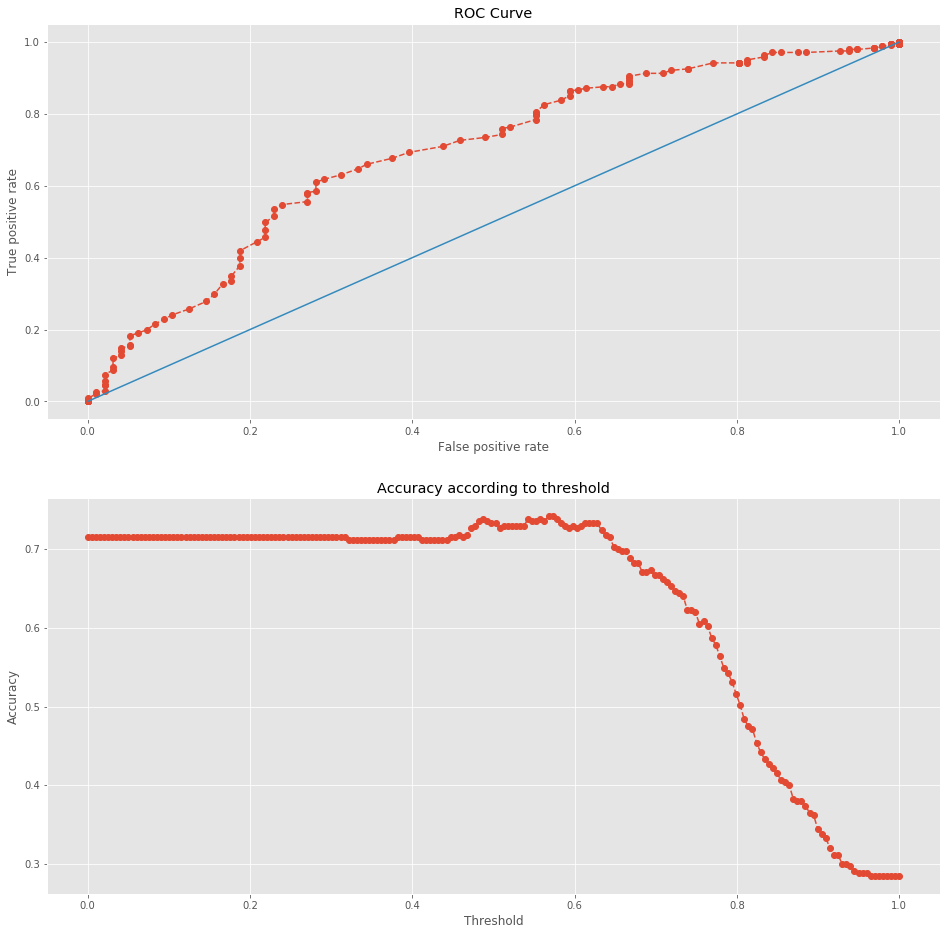

Best Accuracy: 0.7418397626112759
AUC = 0.692621887966805
Precision (The precision is intuitively the ability of the classifier not to label as positive a sample that is negative): 0.7692307692307693
Recall (The recall is intuitively the ability of the classifier to find all the positive samples) 0.9128630705394191


In [7]:
dfbis = df.copy(deep=True)
Ev = Evaluation()
Ev.EvaluateAllLogisticRegression(dfbis)

/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/pytho

Accuracy  Threshold       AUC  Precision    Recall
RandomForest        0.462908   0.864322  0.670881   0.916667  0.273859
LogisticRegression  0.379822   0.879397  0.692622   0.900000  0.149378
GradientBoosting    0.290801   0.969849  0.673409   1.000000  0.008299
SVM                 0.290801   0.804020  0.613135   1.000000  0.008299

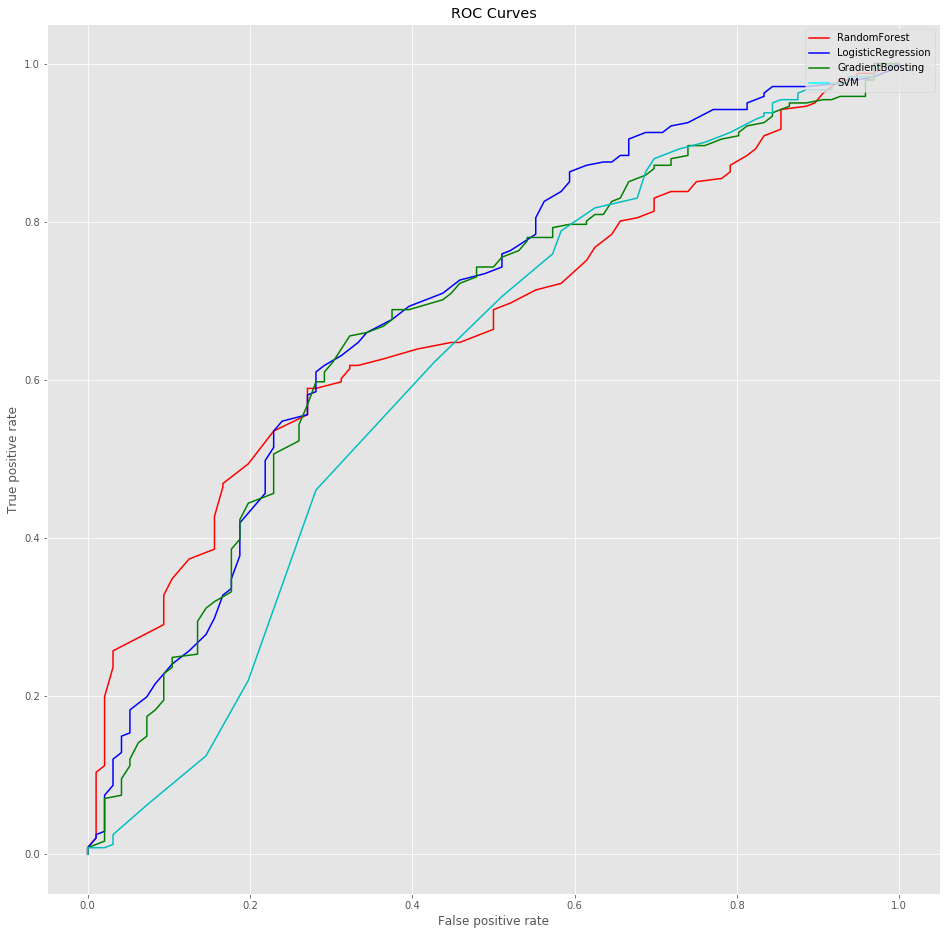

In [27]:
Ev = Evaluation()
dfbis = dfbis.copy(deep=True)
Ev.ModelComparison(dfbis,OptimizeRecall = True, accuracy_min = 0, precision_min = 0.9)

In [13]:
#Doing this slice on the data does not represent any genuine reality
dfbis = df.copy(deep=True)
trainingdata = dfbis[dfbis.index < 841]
trainingdata = trainingdata.sort_index()
newdata = dfbis[dfbis.index >= 841]
newdata = newdata.sort_index()
del newdata["home_score"]
del newdata["away_score"]
Pc=Prediction()
Pc.TeamsMostLikelytoWin(trainingdata,newdata,method="GradientBoosting")

season_order               home_team               away_team  \
841             95       Castres Olympique           USA Perpignan   
842             94                Clermont      Biarritz Olympique   
843             93  Union Sportive Oyonnax        Aviron Bayonnais   
844             97        Stade Toulousain         Bordeaux Begles   
845             98    Stade Francais Paris           USA Perpignan   
846             99  Montpellier Herault RC      Biarritz Olympique   
847            100             Grenoble FC       Castres Olympique   
848            101                Clermont  Union Sportive Oyonnax   
849            102         Bordeaux Begles                CA Brive   
850            103        Aviron Bayonnais        Stade Toulousain   
851            104               Racing 92           RC Toulonnais   
852            105       Castres Olympique         Bordeaux Begles   
853            106           RC Toulonnais             Grenoble FC   
854            109      Biarritz Olympique    Stade Francais Paris   
855            108  Union Sportive Oyonnax               Racing 92   
856            107           USA Perpignan        Aviron Bayonnais   
857            110                CA Brive  Montpellier Herault RC   
858            111        Stade Toulousain                Clermont   
859            112    Stade Francais Paris       Castres Olympique   
861            114  Montpellier Herault RC         Bordeaux Begles   
862            115             Grenoble FC           USA Perpignan   
864            117                CA Brive           RC Toulonnais   
865            118         Bordeaux Begles             Grenoble FC   
866            119                Clermont    Stade Francais Paris   
867            123        Aviron Bayonnais                CA Brive   
868            122       Castres Olympique  Union Sportive Oyonnax   
869            121           RC Toulonnais      Biarritz Olympique   
870            120           USA Perpignan               Racing 92   
871            124        Stade Toulousain  Montpellier Herault RC   
873            126           RC Toulonnais       Castres Olympique   
...            ...                     ...                     ...   
1648           153                    Lyon               Racing 92   
1649           154       Castres Olympique        Stade Toulousain   
1650           155    Stade Francais Paris                Clermont   
1651           156                CA Brive                    Lyon   
1652           157         Bordeaux Begles         Section Paloise   
1653           158                    Agen  Union Sportive Oyonnax   
1654           159  Montpellier Herault RC             La Rochelle   
1655           160               Racing 92           RC Toulonnais   
1656           161           RC Toulonnais  Montpellier Herault RC   
1658           163         Section Paloise                    Agen   
1659           164                Clermont         Bordeaux Begles   
1660           165                    Lyon    Stade Francais Paris   
1661           166             La Rochelle       Castres Olympique   
1662           167        Stade Toulousain               Racing 92   
1663           168           RC Toulonnais       Castres Olympique   
1666           171  Montpellier Herault RC         Section Paloise   
1669           174        Stade Toulousain             La Rochelle   
1670           175         Section Paloise           RC Toulonnais   
1671           176               Racing 92                    Agen   
1672           177                    Lyon  Montpellier Herault RC   
1673           178             La Rochelle    Stade Francais Paris   
1674           179                Clermont        Stade Toulousain   
1675           180       Castres Olympique  Union Sportive Oyonnax   
1676           181                CA Brive         Bordeaux Begles   
1677           182             Grenoble FC  Union Sportive Oyonnax   
1678           1

No handles with labels found to put in legend.


For each feature, the score is the percentage of contribution of the feature to the final result.


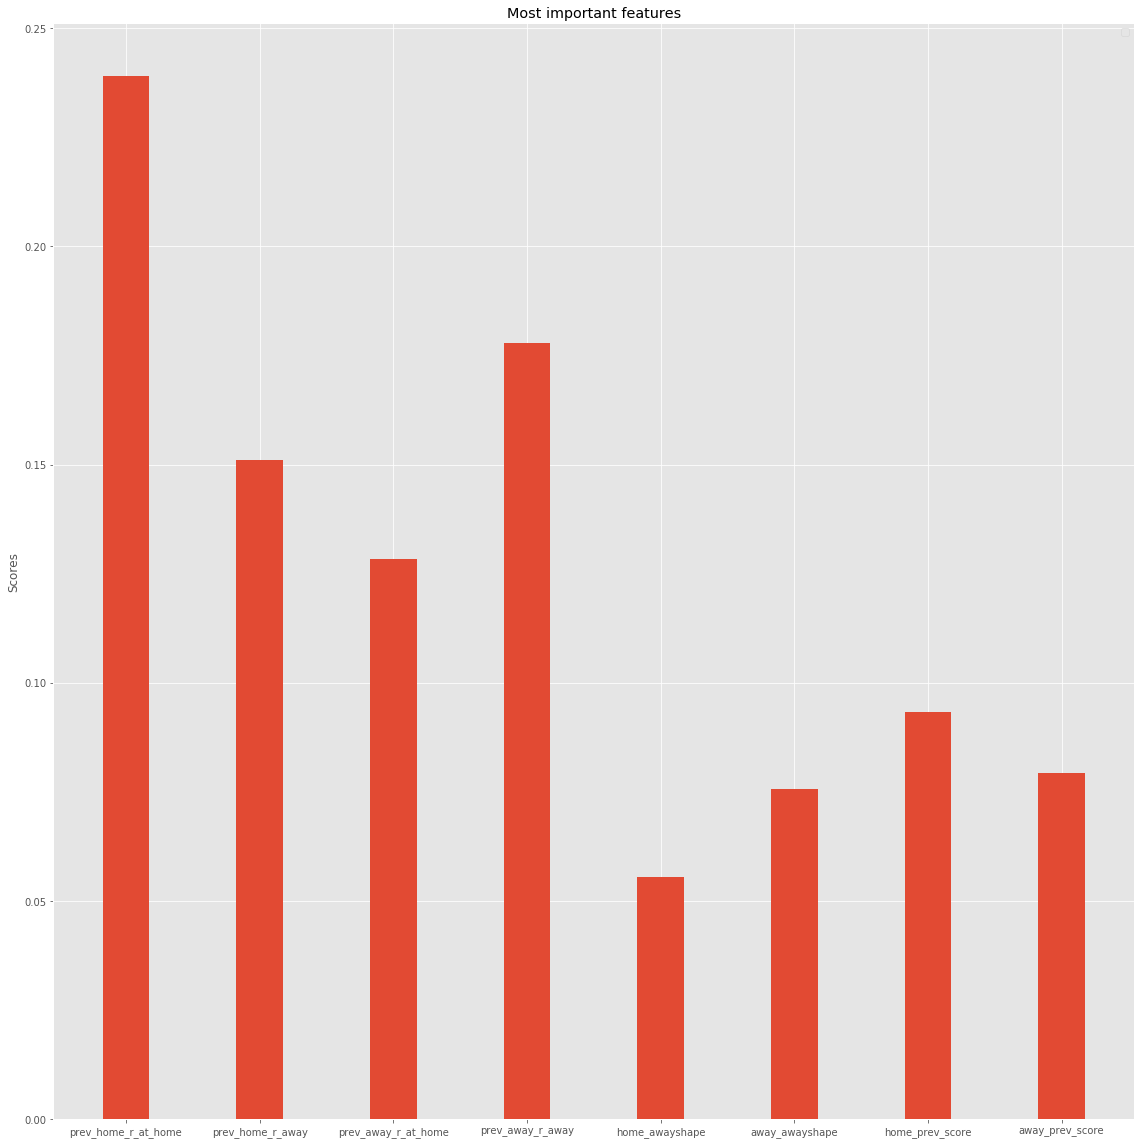

In [14]:
Pc=Prediction()
Pc.MostImportantFeatures(trainingdata,method="GradientBoosting")

/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/noemikati/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning

season_order               home_team               away_team  \
841             95       Castres Olympique           USA Perpignan   
842             94                Clermont      Biarritz Olympique   
843             93  Union Sportive Oyonnax        Aviron Bayonnais   
844             97        Stade Toulousain         Bordeaux Begles   
845             98    Stade Francais Paris           USA Perpignan   
846             99  Montpellier Herault RC      Biarritz Olympique   
847            100             Grenoble FC       Castres Olympique   
848            101                Clermont  Union Sportive Oyonnax   
849            102         Bordeaux Begles                CA Brive   
850            103        Aviron Bayonnais        Stade Toulousain   
851            104               Racing 92           RC Toulonnais   
852            105       Castres Olympique         Bordeaux Begles   
853            106           RC Toulonnais             Grenoble FC   
854            109      Biarritz Olympique    Stade Francais Paris   
855            108  Union Sportive Oyonnax               Racing 92   
856            107           USA Perpignan        Aviron Bayonnais   
857            110                CA Brive  Montpellier Herault RC   
858            111        Stade Toulousain                Clermont   
859            112    Stade Francais Paris       Castres Olympique   
860            113               Racing 92        Stade Toulousain   
861            114  Montpellier Herault RC         Bordeaux Begles   
862            115             Grenoble FC           USA Perpignan   
863            116        Aviron Bayonnais                Clermont   
864            117                CA Brive           RC Toulonnais   
865            118         Bordeaux Begles             Grenoble FC   
866            119                Clermont    Stade Francais Paris   
867            123        Aviron Bayonnais                CA Brive   
868            122       Castres Olympique  Union Sportive Oyonnax   
869            121           RC Toulonnais      Biarritz Olympique   
870            120           USA Perpignan               Racing 92   
...            ...                     ...                     ...   
1653           158                    Agen  Union Sportive Oyonnax   
1654           159  Montpellier Herault RC             La Rochelle   
1655           160               Racing 92           RC Toulonnais   
1656           161           RC Toulonnais  Montpellier Herault RC   
1657           162  Union Sportive Oyonnax                CA Brive   
1658           163         Section Paloise                    Agen   
1659           164                Clermont         Bordeaux Begles   
1660           165                    Lyon    Stade Francais Paris   
1661           166             La Rochelle       Castres Olympique   
1662           167        Stade Toulousain               Racing 92   
1663           168           RC Toulonnais       Castres Olympique   
1664           169  Union Sportive Oyonnax                    Lyon   
1665           170    Stade Francais Paris                CA Brive   
1666           171  Montpellier Herault RC         Section Paloise   
1667           172                    Agen                Clermont   
1668           173         Bordeaux Begles               Racing 92   
1669           174        Stade Toulousain             La Rochelle   
1670           175         Section Paloise           RC Toulonnais   
1671           176               Racing 92                    Agen   
1672           177                    Lyon  Montpellier Herault RC   
1673           178             La Rochelle    Stade Francais Paris   
1674           179                Clermont        Stade Toulousain   
1675           180       Castres Olympique  Union Sportive Oyonnax   
1676           181                CA Brive         Bordeaux Begles   
1677           182             Grenoble FC  Union Sportive Oyonnax   
1678           1

No handles with labels found to put in legend.


For each feature, the score is the percentage of contribution of the feature to the final result.


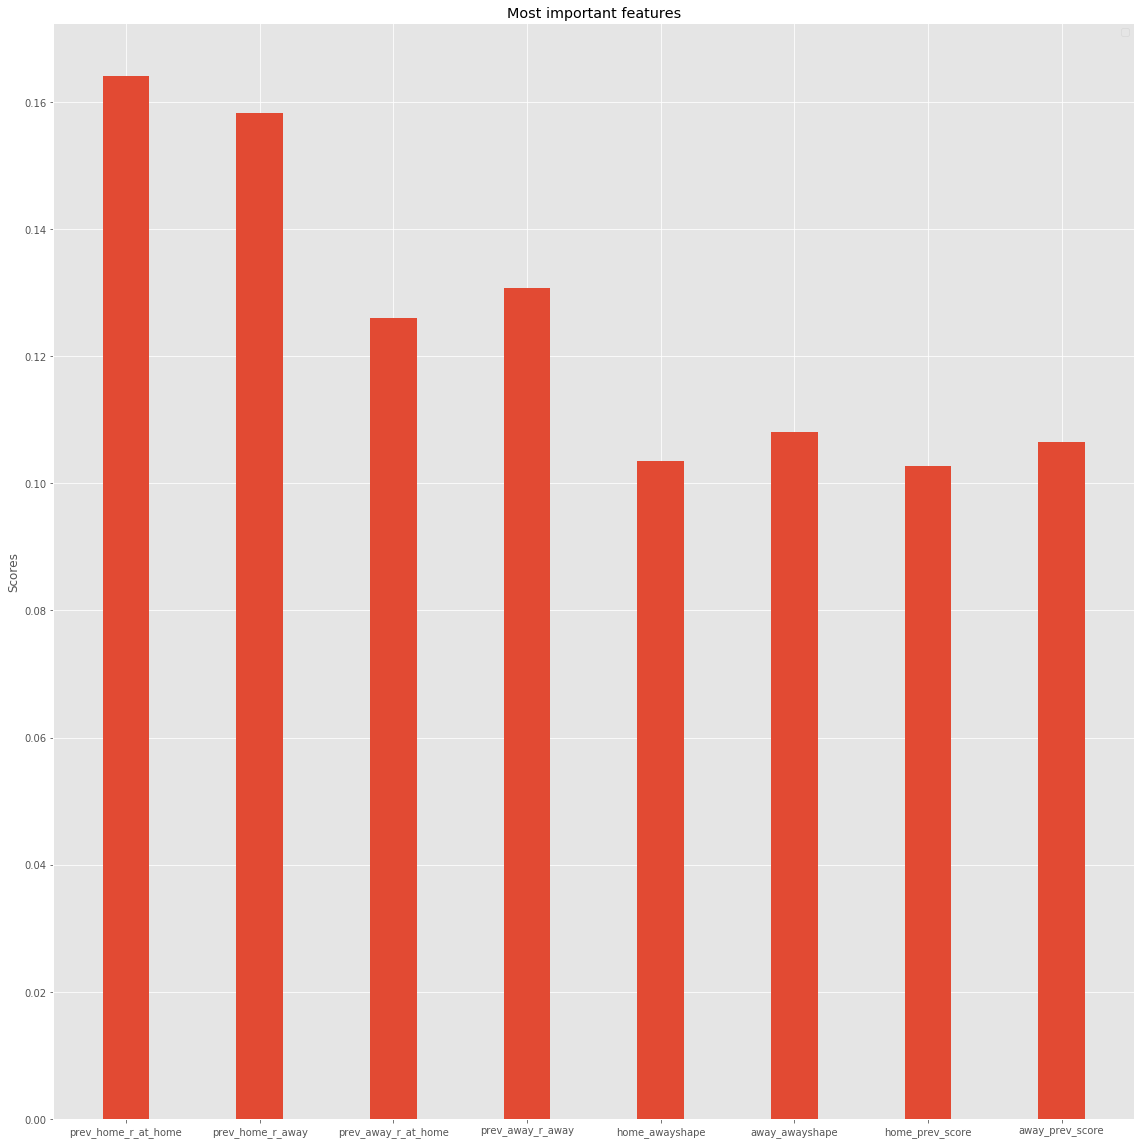

Method used: RandomForest


In [23]:
Op = Optimization()
dfbis = df.copy(deep=True)
trainingdata = dfbis[dfbis.index < 841]
trainingdata = trainingdata.sort_index()
newdata = dfbis[dfbis.index >= 841]
newdata = newdata.sort_index()
del newdata["home_score"]
del newdata["away_score"]
Op.ComputeBestModel(trainingdata,newdata,OptimizePrecision=True,accuracy_min=0,recall_min=0)